In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date
# import proplot as pplt
import ultraplot as uplt
import sys
import os

# --- Correctly configure paths from within the 'examples' directory ---
# Get the project root directory (which is the parent of the current 'examples' directory)
project_root = os.path.dirname(os.getcwd())

# Add the path to the legacy Oliver code so Python can find it
legacy_code_dir = os.path.join(project_root, 'tests', 'data', 'legacy')
sys.path.append(legacy_code_dir)

# Now we can import everything
import marineHeatWaves as oliver_mhw
from mhw3d import bipolarMhwToolBox as ben_mhw

In [2]:
def generate_synthetic_data():
    """
    Generates a synthetic temperature time series based on the example
    in the ecjoliver/marineHeatWaves README.
    """
    # Create time vector
    t_start = date(1982, 1, 1).toordinal()
    t_end = date(2013, 12, 31).toordinal()
    time = np.arange(t_start, t_end + 1)

    # Create synthetic temperature series
    temp = 15. * np.ones(len(time))
    temp += 5. * np.cos(2 * np.pi * (time - 150) / 365.25) # Seasonal cycle
    temp += 0.2 * (time - time[0]) / (time[-1] - time[0]) # Trend
    temp += 0.5 * np.random.randn(len(time)) # Noise
    
    # Add three MHWs
    temp[1000:1050] += 4.0
    temp[4000:4100] += 3.0
    temp[8000:8050] += 5.0

    # Convert ordinal time to datetime64 for xarray/pandas
    time_datetime = np.array([date.fromordinal(t) for t in time]).astype('datetime64[ns]')

    return time_datetime, temp

## First we check that the detection algorithms produce exactly the same results (applying the benMHW detection to the Oliver thresholds)

In [3]:
# 1. Generate the data
time, temp = generate_synthetic_data()

# 2. Run the original Oliver code
t_ordinal = np.array([pd.to_datetime(t).to_pydatetime().toordinal() for t in time])
expected_events, expected_clim = oliver_mhw.detect(t_ordinal, temp)
expected_df = pd.DataFrame(expected_events)

# 3. Prepare input for YOUR toolbox
ssta = temp - expected_clim['seas']
severity = ssta / (expected_clim['thresh'] - expected_clim['seas'])

# 4. Create the xarray.Dataset for your code
ds_input_1d = xr.Dataset(
    data_vars={'ssta': (('time',), ssta), 'severity': (('time',), severity)},
    coords={'time': time}
)
ds_input = ds_input_1d.expand_dims(['lat', 'lon'])

# 5. Run YOUR code
ds_actual_events = ben_mhw.calculate_MHWs_metrics(ds_input)

# 6. Format your results into a clean DataFrame
ds_actual_events = ds_actual_events.squeeze(drop=True).dropna('event', how='all')
actual_df = pd.DataFrame({
    'date_start': ds_actual_events['date_start'].values,
    'date_end': ds_actual_events['date_end'].values,
    'date_peak': ds_actual_events['date_peak'].values,
    'duration': ds_actual_events['duration'].values,
    'intensity_max': ds_actual_events['intensity_max'].values,
    'intensity_mean': ds_actual_events['intensity_mean'].values,
    'intensity_cumulative': ds_actual_events['intensity_cumul'].values,
})


In [4]:
# Select only the columns we want to compare
columns_to_compare = actual_df.columns.tolist()

print("--- Expected Events (Oliver Method) ---")
display(expected_df[columns_to_compare])

print("\n--- Actual Events (Ben-MHW Method) ---")
display(actual_df)

--- Expected Events (Oliver Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-11-01,50,5.260702,3.706867,185.343348
1,1992-12-14,1993-03-23,1993-03-05,100,4.026036,2.830287,283.028666
2,2003-11-27,2004-01-16,2003-12-05,51,6.177509,4.740725,241.776960



--- Actual Events (Ben-MHW Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-11-01,50.0,5.260702,3.706867,185.343348
1,1992-12-14,1993-03-23,1993-03-05,100.0,4.026036,2.830287,283.028666
2,2003-11-27,2004-01-16,2003-12-05,51.0,6.177509,4.740725,241.776960


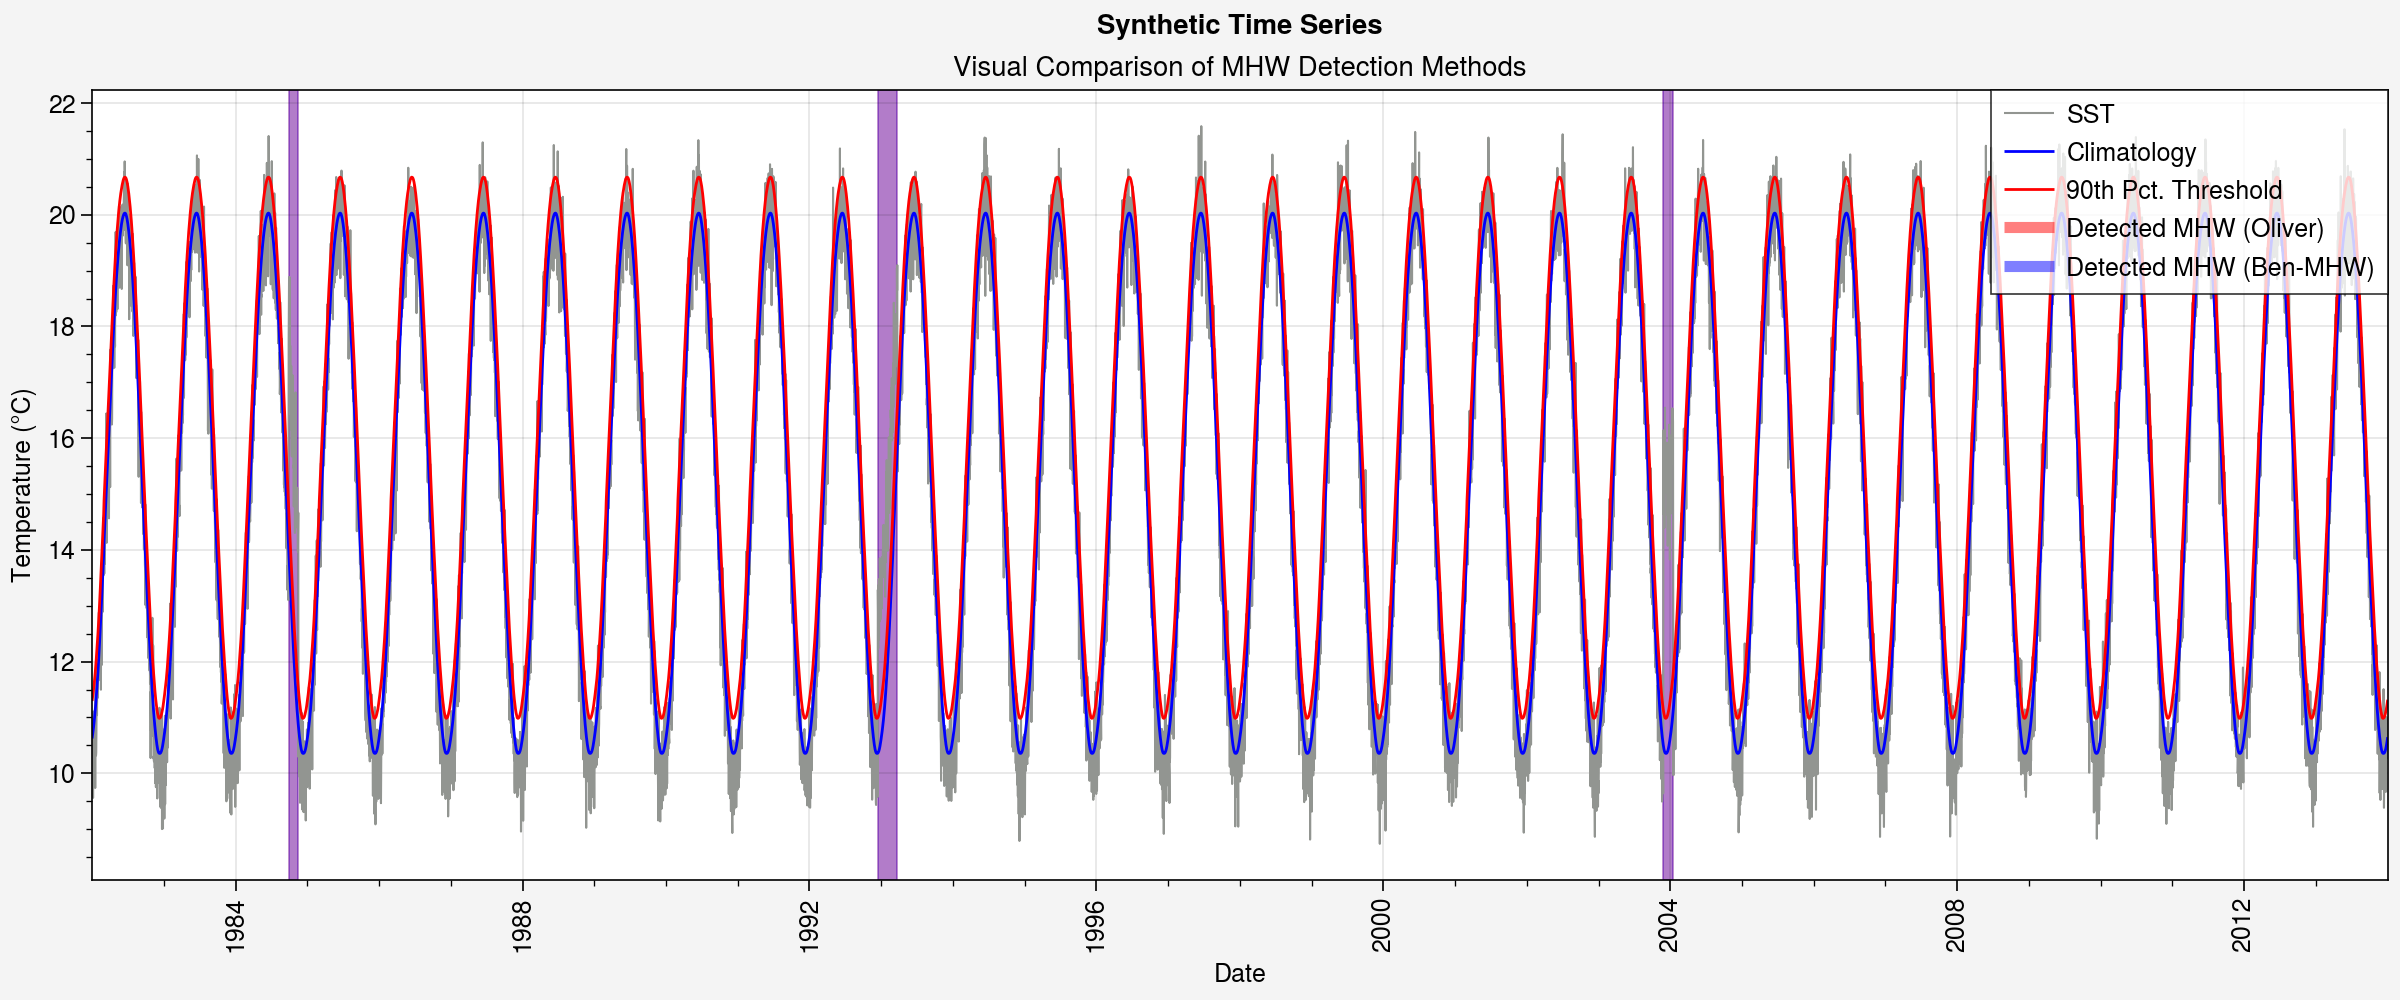

In [5]:
# Create a figure and axes for the plot
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

# Plot the full temperature time series, climatology, and threshold
ax.plot(time, temp, color='gray', lw=0.75, label='SST')
ax.plot(time, expected_clim['seas'], color='blue', lw=1, label='Climatology')
ax.plot(time, expected_clim['thresh'], color='red', lw=1, label='90th Pct. Threshold')

# Highlight the detected MHWs from both methods
# Use different colors with transparency to see the overlap
for i, event in expected_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='red', alpha=0.3)

for i, event in actual_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='blue', alpha=0.3)

# Add clear legend entries
ax.plot([], [], color='red', lw=4, alpha=0.5, label='Detected MHW (Oliver)')
ax.plot([], [], color='blue', lw=4, alpha=0.5, label='Detected MHW (Ben-MHW)')

# Format the plot
ax.format(
    title='Visual Comparison of MHW Detection Methods',
    xlabel='Date',
    ylabel='Temperature (°C)',
    suptitle='Synthetic Time Series'
)
ax.legend(ncols=1, loc='upper right')

uplt.show()

## Then compare the climatologies and thresholds between the two codes:

Calculating 366-day climatology using the ben-mhw toolbox...
Calculation complete.
Summarizing the Oliver code's daily output...
Summarizing complete.


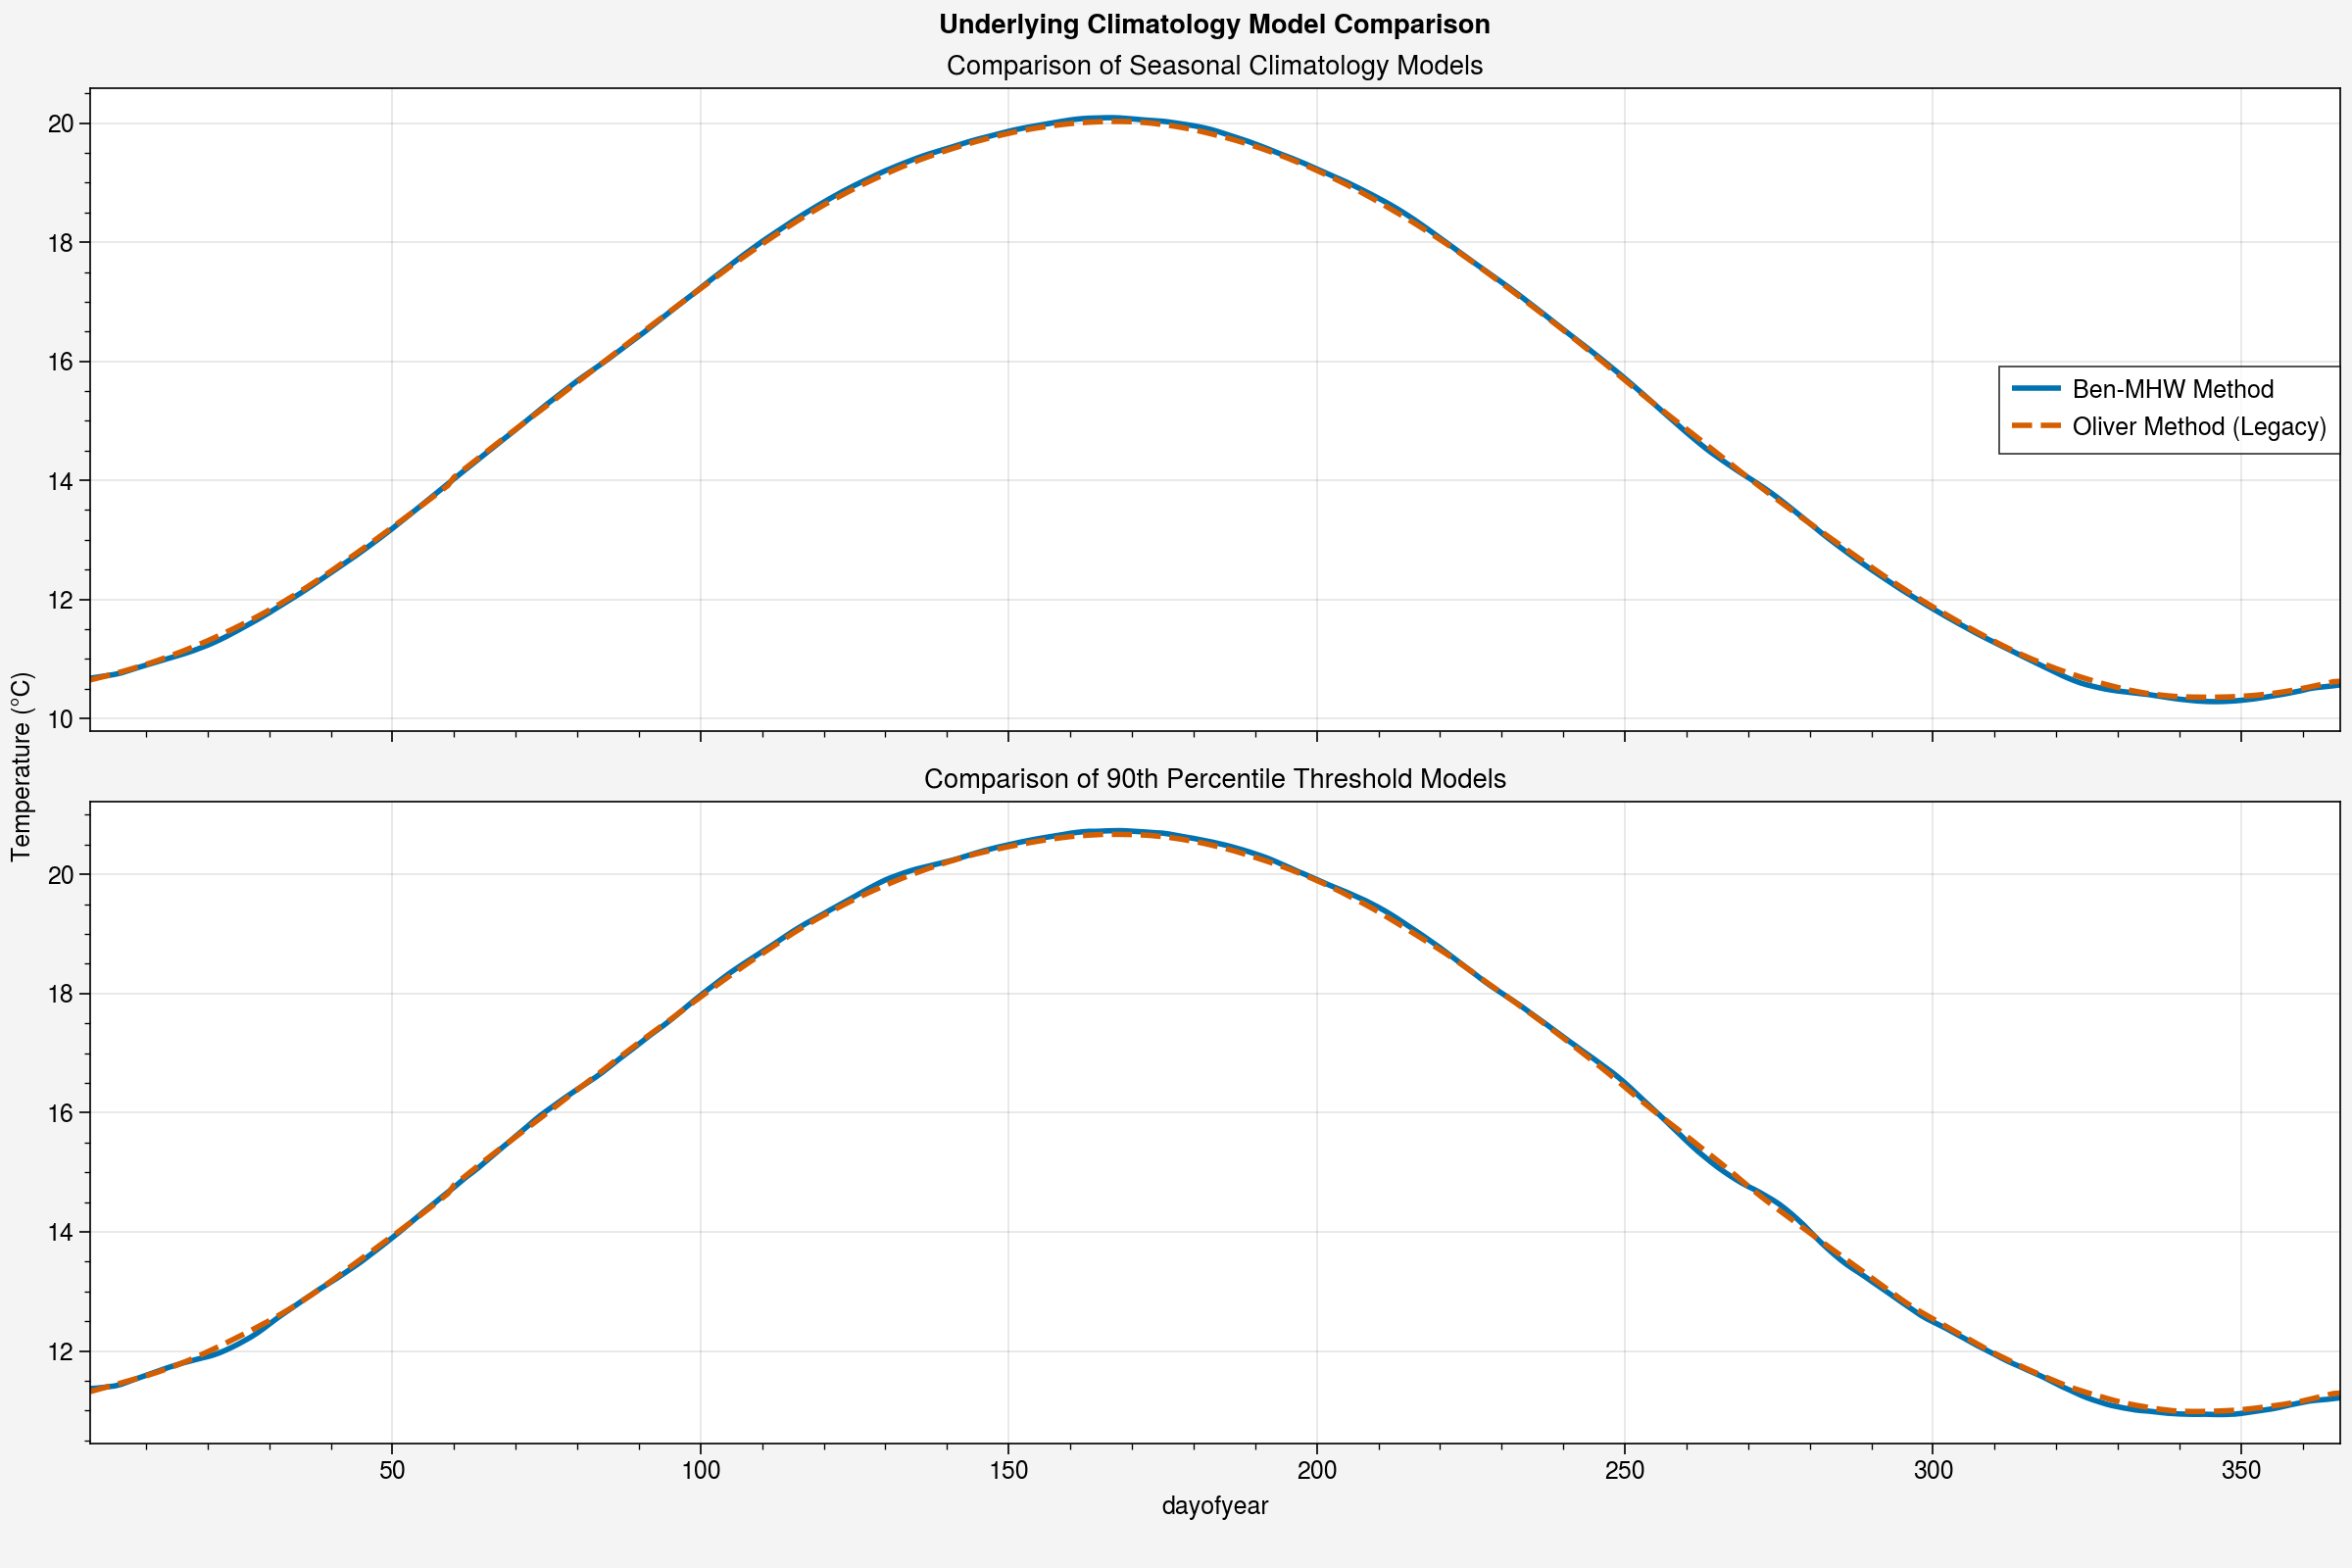

In [6]:
# --- Cell 6: The Correct Climatology Comparison ---

# 1. Calculate the 366-day summary climatology with YOUR ben-mhw code
print("Calculating 366-day climatology using the ben-mhw toolbox...")
ds_for_clim = xr.Dataset(
    data_vars={'temp': (('time',), temp)},
    coords={'time': time}
).expand_dims(['lat', 'lon'])

actual_seas_summary = ben_mhw.smoothedClima_mhw(ds_for_clim.temp).squeeze()
actual_thresh_summary = ben_mhw.smoothedThresh_mhw(ds_for_clim.temp).squeeze()
print("Calculation complete.")


# 2. Convert the Oliver code's DAILY output into a 366-day summary
print("Summarizing the Oliver code's daily output...")
# Create a temporary xarray.DataArray from the Oliver code's daily output
oliver_daily_clim = xr.DataArray(
    expected_clim['seas'], dims=['time'], coords={'time': time}
)
oliver_daily_thresh = xr.DataArray(
    expected_clim['thresh'], dims=['time'], coords={'time': time}
)

# Now, group by day-of-year and average to create the 366-day summary
expected_seas_summary = oliver_daily_clim.groupby('time.dayofyear').mean()
expected_thresh_summary = oliver_daily_thresh.groupby('time.dayofyear').mean()
print("Summarizing complete.")


# 3. Create the definitive comparison plot
fig, axs = uplt.subplots(nrows=2, figsize=(12, 8), tight=True, sharex=True)

# Plot Seasonal Climatologies
axs[0].plot(actual_seas_summary, lw=2, label='Ben-MHW Method')
axs[0].plot(expected_seas_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[0].format(
    title='Comparison of Seasonal Climatology Models',
    ylabel='Temperature (°C)'
)
axs[0].legend(ncols=1, loc='best')

# Plot 90th Percentile Thresholds
axs[1].plot(actual_thresh_summary, lw=2, label='Ben-MHW Method')
axs[1].plot(expected_thresh_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[1].format(
    title='Comparison of 90th Percentile Threshold Models',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)

fig.format(suptitle='Underlying Climatology Model Comparison')
uplt.show()

In [7]:
actual_seas_summary

<xarray.DataArray 'temp' (dayofyear: 366)> Size: 3kB
array([10.67579935, 10.69109104, 10.70701334, 10.72338376, 10.74092374,
       10.7641754 , 10.79746751, 10.8310067 , 10.86380822, 10.8945982 ,
       10.92483737, 10.95511638, 10.98683978, 11.01782587, 11.0490345 ,
       11.08019218, 11.11340429, 11.15000648, 11.1886479 , 11.22920948,
       11.27400895, 11.32193967, 11.37323396, 11.42725061, 11.48283054,
       11.53938407, 11.59633811, 11.65424752, 11.71411758, 11.77540924,
       11.8395413 , 11.9038771 , 11.96828775, 12.03225893, 12.09728044,
       12.16496519, 12.23409638, 12.30472157, 12.37521699, 12.44450598,
       12.51523134, 12.5860259 , 12.65712918, 12.72960749, 12.80365967,
       12.87896932, 12.95481908, 13.03202214, 13.11002654, 13.19027893,
       13.27270359, 13.35476442, 13.43695174, 13.52053647, 13.60422628,
       13.68790635, 13.7717106 , 13.85654666, 13.94117102, 14.02533629,
       14.10839907, 14.19126839, 14.27344665, 14.35598204, 14.43920365,
       14.52256714, 14.60542876, 14.68716099, 14.76806345, 14.85090149,
       14.93567737, 15.02083915, 15.105705  , 15.19088786, 15.27354993,
       15.3539124 , 15.43377991, 15.51342001, 15.59298027, 15.67096367,
       15.74510386, 15.81666861, 15.88812017, 15.96087995, 16.03520116,
       16.11249871, 16.19047873, 16.26793953, 16.34461222, 16.4215707 ,
       16.50016124, 16.58218217, 16.66572659, 16.74785127, 16.82860199,
       16.90842943, 16.98770568, 17.06740693, 17.14765135, 17.230252  ,
...
       13.9814272 , 13.9128653 , 13.84188278, 13.76844974, 13.69126284,
       13.61033802, 13.52811872, 13.44502003, 13.36154073, 13.27681976,
       13.1910003 , 13.10750164, 13.02619565, 12.94727926, 12.86899665,
       12.79192038, 12.71693131, 12.64362293, 12.57081639, 12.49862831,
       12.4279606 , 12.35899909, 12.29012035, 12.22233143, 12.15466357,
       12.08991455, 12.02605563, 11.96256991, 11.8996935 , 11.83900071,
       11.77925918, 11.71959329, 11.6605014 , 11.60271197, 11.54527947,
       11.48910135, 11.43237748, 11.37834836, 11.32606747, 11.27493802,
       11.22325745, 11.17250537, 11.12242126, 11.07111238, 11.01870685,
       10.9676425 , 10.91779456, 10.86859186, 10.81826199, 10.7678167 ,
       10.7182387 , 10.67271903, 10.63104287, 10.59404416, 10.56342248,
       10.53772011, 10.51420862, 10.49284378, 10.47538916, 10.46034102,
       10.44851359, 10.43837036, 10.42663445, 10.41407726, 10.40024352,
       10.38417302, 10.36749129, 10.35143574, 10.33696341, 10.32312387,
       10.31192708, 10.30108449, 10.2920668 , 10.28603175, 10.28244201,
       10.28181238, 10.28392145, 10.28829587, 10.29486017, 10.30360059,
       10.31448961, 10.32684776, 10.3415663 , 10.35809325, 10.37497311,
       10.39198247, 10.40980183, 10.42949106, 10.45025707, 10.47195894,
       10.49851485, 10.51525624, 10.52620833, 10.53711169, 10.54828339,
       10.56193159])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [8]:
expected_seas_summary

<xarray.DataArray (dayofyear: 366)> Size: 3kB
array([10.64772031, 10.67315374, 10.69925207, 10.72608627, 10.75388205,
       10.78239802, 10.81169964, 10.84232163, 10.87404547, 10.90609592,
       10.94056883, 10.97630414, 11.0135592 , 11.05185303, 11.09099523,
       11.13085778, 11.17197768, 11.21462219, 11.25871055, 11.30333432,
       11.34982434, 11.39714765, 11.44639201, 11.49594905, 11.54696032,
       11.59887212, 11.65169612, 11.70663932, 11.76249668, 11.81934895,
       11.87885107, 11.93956689, 12.00156661, 12.06496709, 12.12986256,
       12.1964325 , 12.26381738, 12.33241601, 12.40168968, 12.47214183,
       12.54445062, 12.61678694, 12.68946276, 12.76297003, 12.83606047,
       12.90929245, 12.98341349, 13.05883643, 13.13475787, 13.21077092,
       13.28758146, 13.36444314, 13.44118973, 13.5182862 , 13.59658392,
       13.6752653 , 13.7539203 , 13.83302658, 13.91224928, 14.05281455,
       14.13393077, 14.21504624, 14.29667007, 14.37815413, 14.45917208,
       14.53967071, 14.61989878, 14.69991058, 14.77955077, 14.85867911,
       14.93733056, 15.01540531, 15.09325126, 15.1710497 , 15.25002117,
       15.33013062, 15.41010966, 15.4895583 , 15.56861698, 15.64773445,
       15.72708802, 15.80657823, 15.88639008, 15.96628916, 16.04577205,
       16.12505163, 16.204481  , 16.28368262, 16.36295021, 16.44242181,
       16.52156257, 16.60009728, 16.67808183, 16.75564325, 16.83334113,
       16.91131801, 16.98899931, 17.06636656, 17.14348961, 17.22065194,
...
       13.96601968, 13.88685375, 13.80869281, 13.73105273, 13.65410497,
       13.57758534, 13.50161859, 13.42614237, 13.35119991, 13.27704196,
       13.20311766, 13.12918921, 13.05560996, 12.9821502 , 12.90831181,
       12.83426698, 12.76046694, 12.68689136, 12.61385504, 12.54121709,
       12.46887867, 12.39766467, 12.32809968, 12.25952922, 12.19192109,
       12.12547807, 12.06050622, 11.99677578, 11.9341106 , 11.87240935,
       11.81156879, 11.7514166 , 11.69194462, 11.63211834, 11.57299422,
       11.51491512, 11.45817995, 11.4020003 , 11.3467802 , 11.29258945,
       11.23938276, 11.18757562, 11.13764006, 11.08924231, 11.04310506,
       10.9987357 , 10.95579369, 10.91412516, 10.87411186, 10.83524321,
       10.7978426 , 10.76198102, 10.72749487, 10.693951  , 10.66155698,
       10.63020457, 10.60015109, 10.57145807, 10.54421279, 10.51853659,
       10.49444042, 10.47209656, 10.45157477, 10.43289564, 10.41681272,
       10.40275753, 10.39076657, 10.38038818, 10.37181422, 10.36537252,
       10.36106019, 10.35845147, 10.35701473, 10.35643721, 10.35639756,
       10.3569494 , 10.35838947, 10.36105364, 10.36525043, 10.37081364,
       10.37764857, 10.38534752, 10.39452627, 10.40547242, 10.41786796,
       10.43230852, 10.44798956, 10.46539908, 10.48416387, 10.50412096,
       10.52544552, 10.54716909, 10.56983884, 10.59333571, 10.61699213,
       10.62290517])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

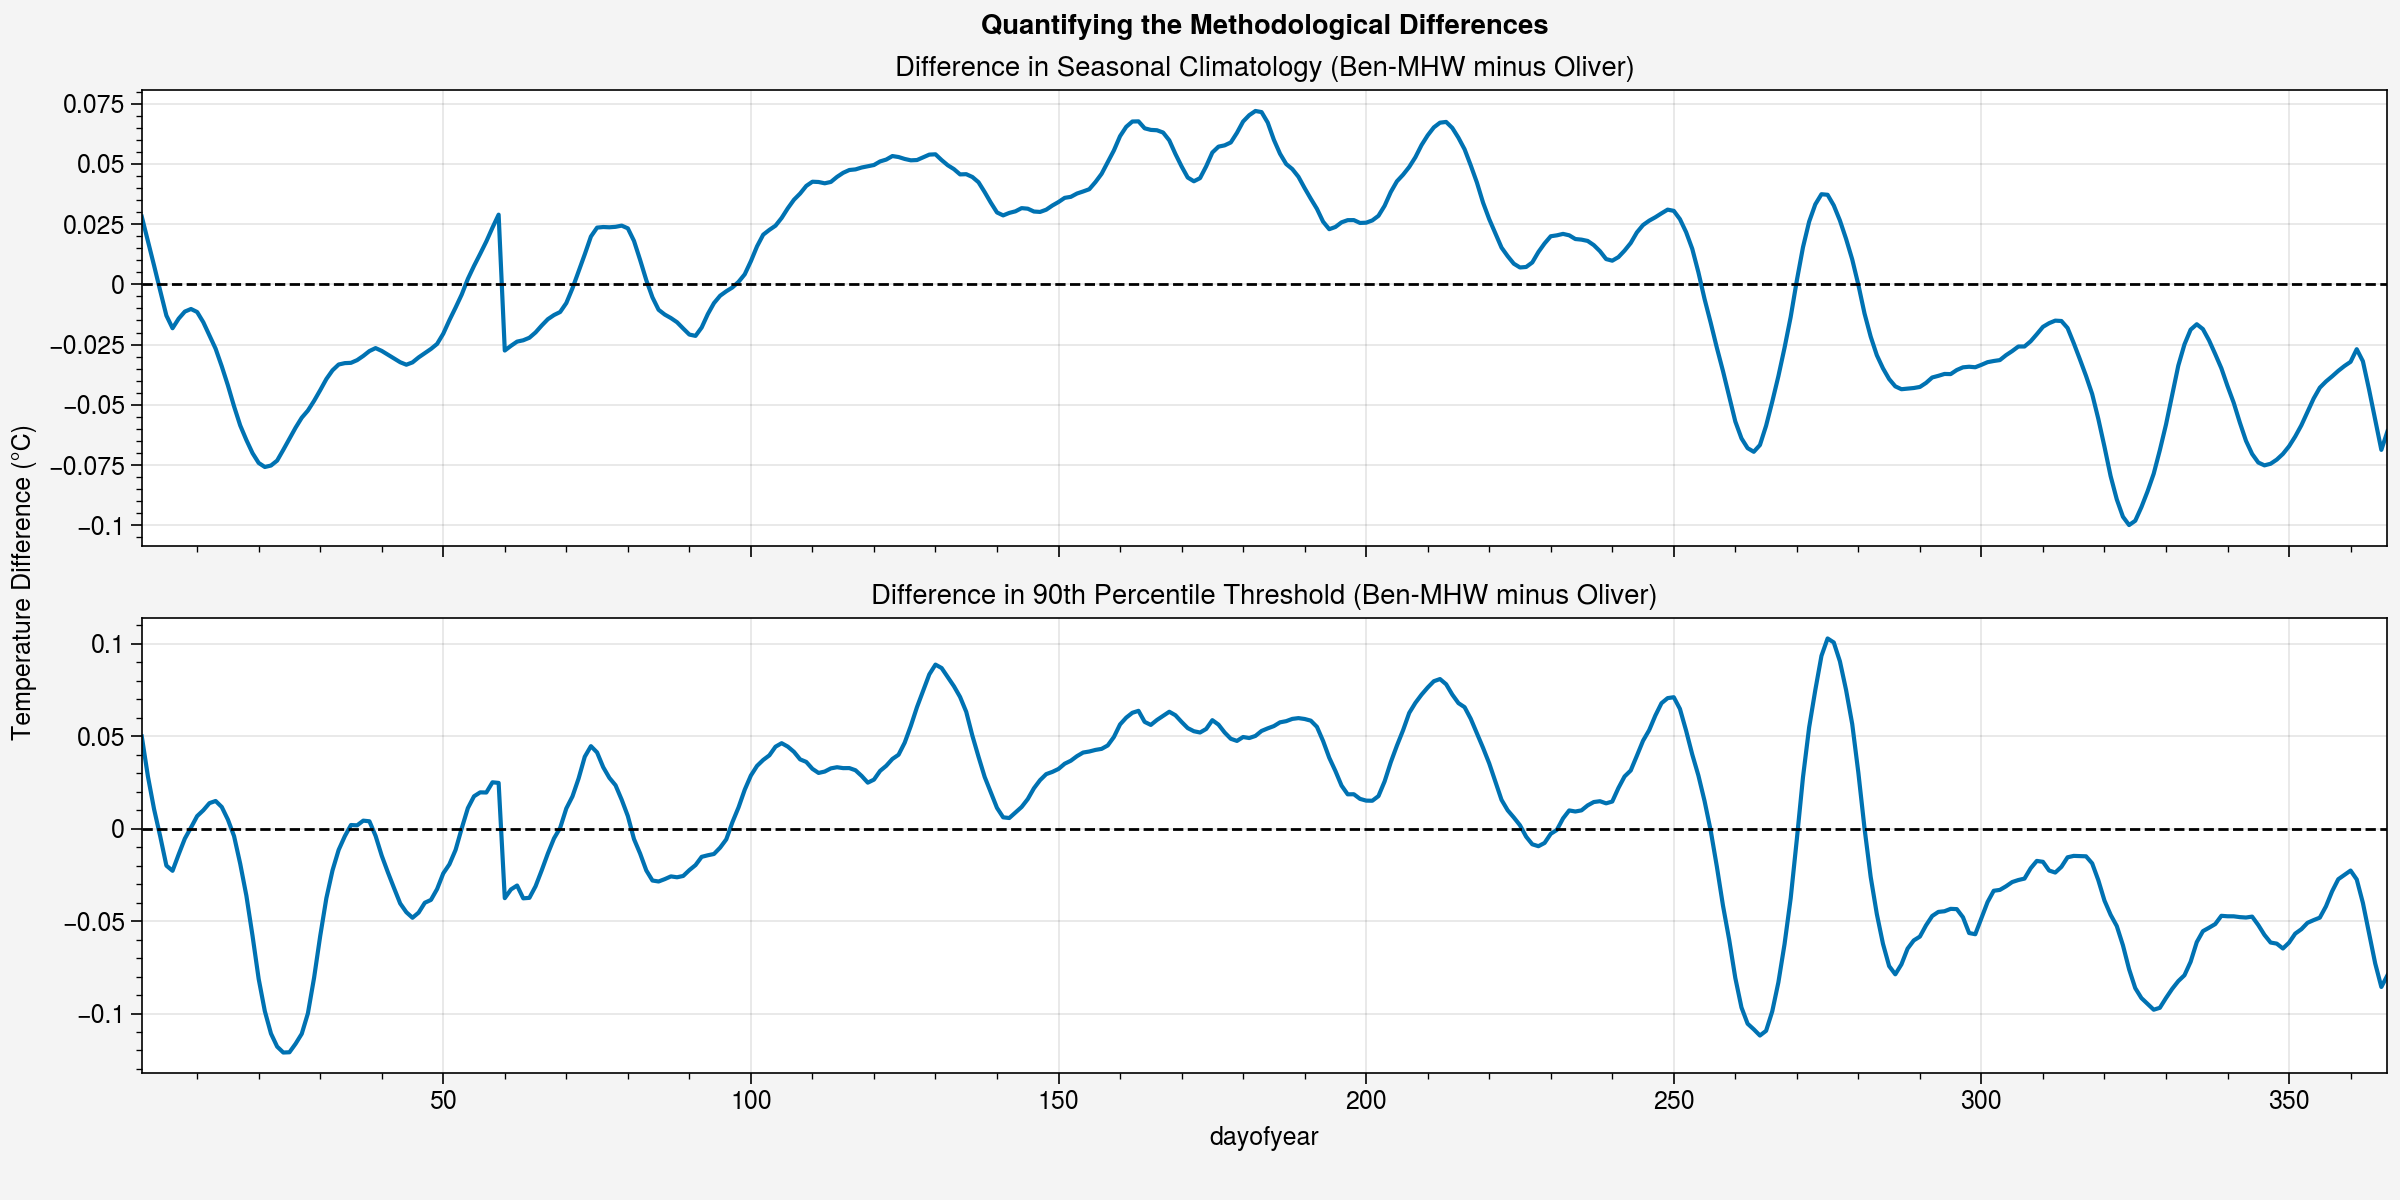

Maximum absolute difference in climatology: 0.0999 °C
Maximum absolute difference in threshold: 0.1211 °C


In [9]:
# --- Cell 7: Numerical Difference Analysis ---

# Calculate the difference between the two climatology models
climatology_difference = actual_seas_summary.values - expected_seas_summary.values

# Calculate the difference between the two threshold models
threshold_difference = actual_thresh_summary.values - expected_thresh_summary.values


# Create a new plot to visualize JUST the difference
fig, axs = uplt.subplots(nrows=2, figsize=(12, 6), tight=True, sharex=True)

# Plot the difference in seasonal climatologies
axs[0].plot(actual_seas_summary.dayofyear, climatology_difference)
axs[0].axhline(0, color='k', linestyle='--', lw=1) # Add a zero line for reference
axs[0].format(
    title='Difference in Seasonal Climatology (Ben-MHW minus Oliver)',
    ylabel='Temperature Difference (°C)'
)

# Plot the difference in 90th percentile thresholds
axs[1].plot(actual_thresh_summary.dayofyear, threshold_difference)
axs[1].axhline(0, color='k', linestyle='--', lw=1)
axs[1].format(
    title='Difference in 90th Percentile Threshold (Ben-MHW minus Oliver)',
    xlabel='Day of Year',
    ylabel='Temperature Difference (°C)'
)

fig.format(suptitle='Quantifying the Methodological Differences')
uplt.show()

# Print the maximum absolute difference to quantify the magnitude
print(f"Maximum absolute difference in climatology: {np.abs(climatology_difference).max():.4f} °C")
print(f"Maximum absolute difference in threshold: {np.abs(threshold_difference).max():.4f} °C")

Calculating RAW (unsmoothed) percentile values for each day-of-year...
Raw value calculation complete.


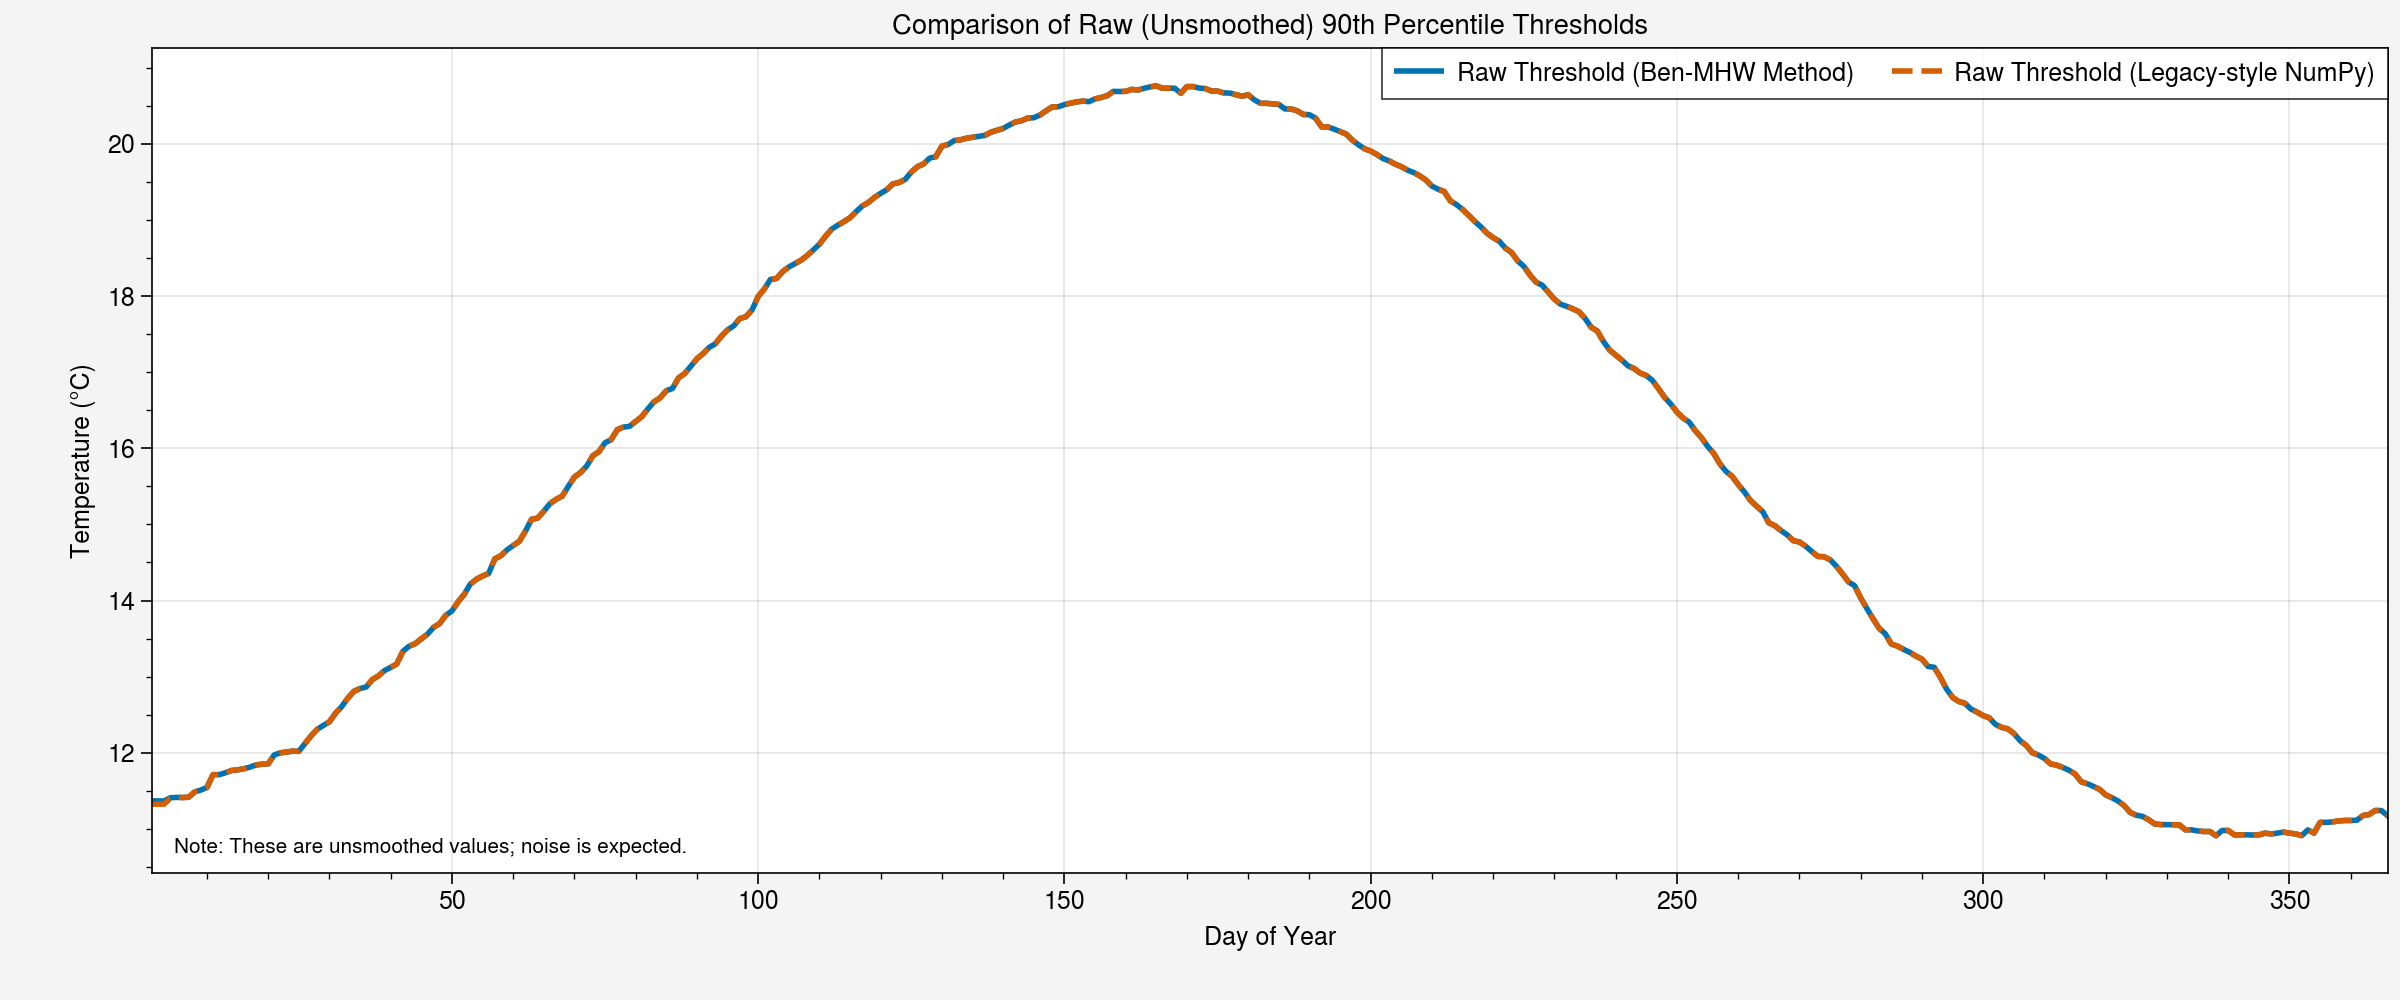

In [11]:
# --- Cell 7: Due Diligence - Raw (Unsmoothed) Threshold Analysis (Corrected) ---

print("Calculating RAW (unsmoothed) percentile values for each day-of-year...")

# We need the dayofyear array from our time coordinate for grouping
doy = ds_for_clim.time.dt.dayofyear

# --- Method 1: Replicate your ben-mhw logic (using xarray) ---
raw_actual_thresh = []
for day in range(1, 367):
    if day <= 366 - 5:
        window = ds_for_clim.temp.where((doy >= day - 5) & (doy <= day + 5), drop=True)
    else:
        window = ds_for_clim.temp.where((doy >= day - 5) | (doy <= (day + 5) % 366), drop=True)
    
    percentile_val = window.quantile(0.9, dim='time', skipna=False)
    raw_actual_thresh.append(percentile_val.item())

# --- Method 2: Replicate the legacy logic (using basic NumPy) ---
raw_expected_thresh = []
temp_np = ds_for_clim.temp.values.flatten()
doy_np = doy.values

for day in range(1, 367):
    days_in_window = np.arange(day - 5, day + 6)
    days_in_window[days_in_window < 1] += 366
    days_in_window[days_in_window > 366] -= 366
    
    indices_in_window = np.isin(doy_np, days_in_window)
    percentile_val = np.percentile(temp_np[indices_in_window], 90)
    raw_expected_thresh.append(percentile_val)

print("Raw value calculation complete.")

# --- Create the comparison plot ---
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

day_of_year_axis = np.arange(1, 367)
ax.plot(day_of_year_axis, raw_actual_thresh, lw=2, label='Raw Threshold (Ben-MHW Method)')
ax.plot(day_of_year_axis, raw_expected_thresh, lw=2, linestyle='--', label='Raw Threshold (Legacy-style NumPy)')
ax.plot([], [], lw=0)

# The proplot equivalent of 'axes fraction' is just 'axes'
ax.text(0.01, 0.02, 'Note: These are unsmoothed values; noise is expected.', transform='axes', ha='left', va='bottom', fontsize='small') # <--- THIS IS THE CORRECTED LINE

ax.format(
    title='Comparison of Raw (Unsmoothed) 90th Percentile Thresholds',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
uplt.show()

Isolating and comparing the smoothing function itself...
Smoothing comparison complete.


/tmp/ipykernel_65863/2131849628.py:14: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  final_actual_smooth = smoothed_actual.where(smoothed_actual.year==1, drop=True).drop('year').rename({'time':'dayofyear'})


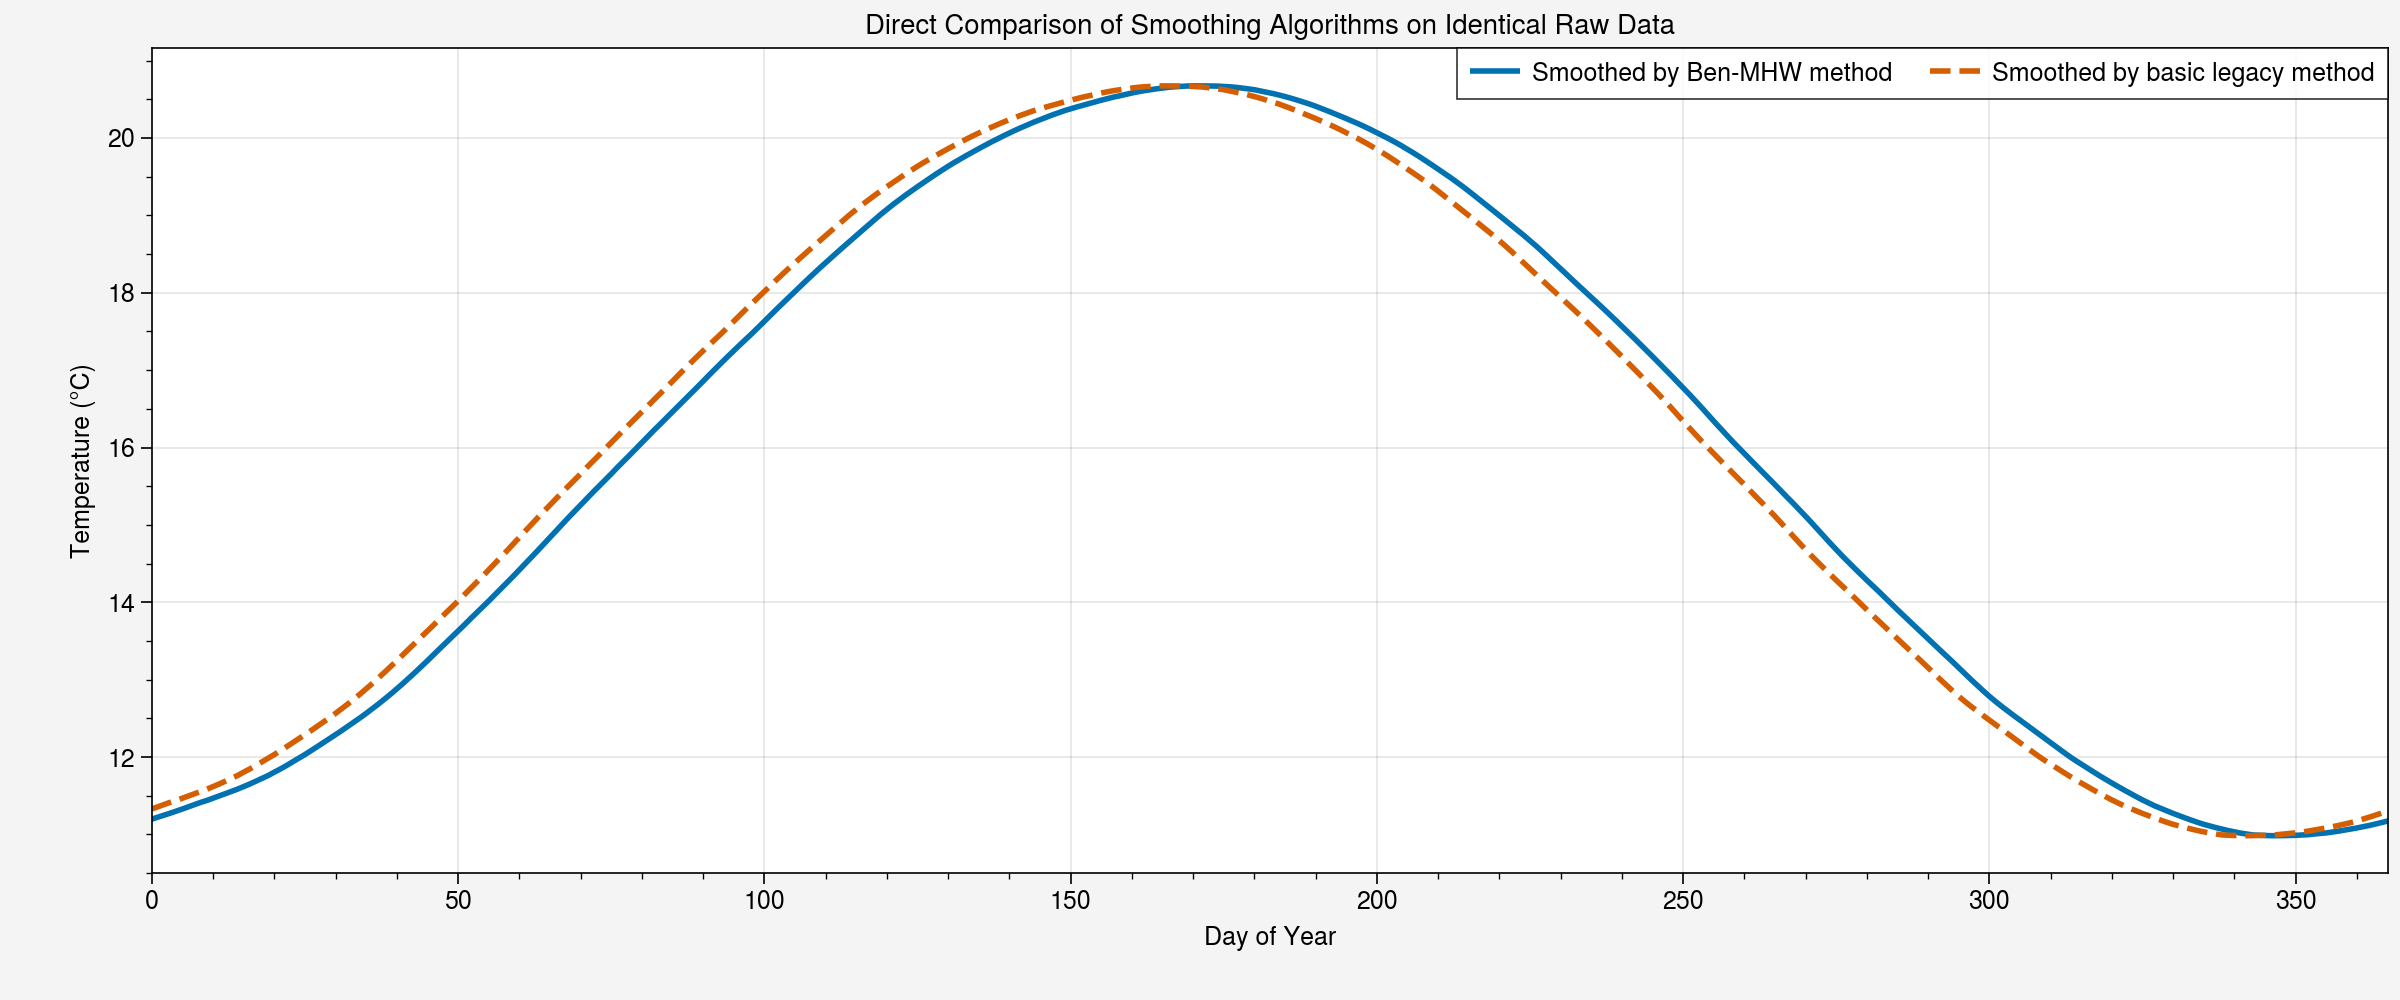

In [12]:
# --- Cell 8: The Final Test - Isolating the Smoothing Algorithm ---

print("Isolating and comparing the smoothing function itself...")

# Let's use the 'raw_expected_thresh' as the identical input for both smoothers
input_raw_thresholds = np.array(raw_expected_thresh)

# --- Smoothing Method 1: Your ben-mhw implementation ---
# We replicate the logic from your smoothedThresh_mhw function
# Convert to an xarray.DataArray to use xarray's tools
thresh_da = xr.DataArray(input_raw_thresholds, dims=['dayofyear'], coords={'dayofyear': np.arange(1, 367)})
stacked_actual = xr.concat([thresh_da, thresh_da, thresh_da], dim='year').stack(time=('year', 'dayofyear')).roll(time=5)
smoothed_actual = stacked_actual.rolling(time=31, min_periods=1, center=True).mean()
final_actual_smooth = smoothed_actual.where(smoothed_actual.year==1, drop=True).drop('year').rename({'time':'dayofyear'})


# --- Smoothing Method 2: A simplified, pure legacy-style implementation ---
# We use pandas which has a rolling mean closer to older implementations
s = pd.Series(np.concatenate([input_raw_thresholds] * 3))
# Note: No .roll() command here
final_expected_smooth = s.rolling(window=31, min_periods=1, center=True).mean().iloc[366:366*2].values

print("Smoothing comparison complete.")

# --- Create the comparison plot ---
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

ax.plot(final_actual_smooth.dayofyear, final_actual_smooth.values, lw=2, label='Smoothed by Ben-MHW method')
ax.plot(final_actual_smooth.dayofyear, final_expected_smooth, lw=2, linestyle='--', label='Smoothed by basic legacy method')

ax.format(
    title='Direct Comparison of Smoothing Algorithms on Identical Raw Data',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
uplt.show()

In [13]:
# --- Cell 9: Exporting the Smoothed Numerical Data ---

print("="*50)
print(" Smoothed Data from Your Ben-MHW Method")
print("="*50)
# We print the .values to get the raw numpy array
print(final_actual_smooth.values)


print("\n\n" + "="*50)
print(" Smoothed Data from the Basic Legacy-Style Method")
print("="*50)
print(final_expected_smooth)

 Smoothed Data from Your Ben-MHW Method
[11.19775005 11.22288759 11.24843363 11.27454145 11.30137833 11.32896849
 11.35797756 11.38547035 11.41471863 11.43952105 11.46812625 11.49742903
 11.52662839 11.55603064 11.58533689 11.61781998 11.65156198 11.68763906
 11.72367872 11.76126593 11.80469743 11.84599352 11.89087372 11.93870849
 11.9854109  12.03210799 12.08211332 12.13353672 12.18499038 12.23698198
 12.28938987 12.34167153 12.39609718 12.45086602 12.50669033 12.56415974
 12.62412524 12.68499785 12.74848146 12.81339893 12.88208968 12.95012664
 13.02162381 13.09486333 13.1690786  13.24451449 13.32281889 13.39921314
 13.47531193 13.55161104 13.62815579 13.70530112 13.78473575 13.86112015
 13.93744079 14.01579554 14.09530859 14.17306006 14.25339221 14.33542428
 14.41801889 14.50184143 14.58472591 14.66722679 14.75237742 14.83680009
 14.92354068 15.00842437 15.09204256 15.17419656 15.25659101 15.33840774
 15.42006227 15.49907333 15.57899898 15.65850204 15.74137166 15.81994044
 15.9002224